# The first experiment: use generated dataset from sklearn to evaluate the trade-off power of different algorithms.


In [2]:
%load_ext autoreload
%autoreload 2
from lib.reduction_algorithms import EGDIS, POP, CL, WCL
from lib.callbacks import MonitorAndSaveParameters
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.neural_network import MLPClassifier
from keras.utils import to_categorical
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import keras

Using TensorFlow backend.


In [3]:
def show_training(history, idx=None):
    
    acc = history['acc']
    val_acc = history["val_acc"]

    loss = history['loss']
    val_loss = history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot([np.argmax(val_acc), np.argmax(val_acc)],
          plt.ylim(), label='Best accuracy: ' + str(np.max(val_acc)))
    plt.legend(loc='upper right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    # plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [47]:
sample_blobs, sample_blobs_y = make_blobs(n_samples=2000, centers=2, shuffle=True, n_features=2, cluster_std=2)
sample_moons, sample_moons_y = make_moons(n_samples=2000, shuffle=True, noise=0.1)
sample_circles, sample_circles_y = make_circles(n_samples=2000, shuffle=True, noise=0.05)

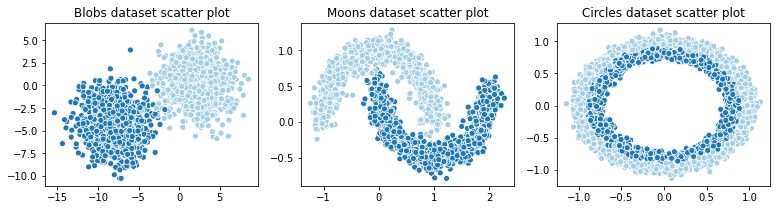

In [88]:
axes = plt.subplots(1,3, figsize=(13,3))
sns.scatterplot(sample_blobs[:,0], sample_blobs[:,1], hue=sample_blobs_y, ax=axes[1][0], legend=False, palette=sns.color_palette("Paired", 2))

axes[1][0].set_title("Blobs dataset scatter plot")
sns.scatterplot(sample_moons[:,0], sample_moons[:,1], hue=sample_moons_y, ax=axes[1][1], legend=False, palette=sns.color_palette("Paired", 2))
axes[1][1].set_title("Moons dataset scatter plot")
sns.scatterplot(sample_circles[:,0], sample_circles[:,1], hue=sample_circles_y, ax=axes[1][2], legend=False, palette=sns.color_palette("Paired", 2))
axes[1][2].set_title("Circles dataset scatter plot")
plt.show()

In [49]:
def check_distribution(x, y, axes, name):
    x_train, x_valid, x_test = np.split(x, [int(.6 * len(x)), int(.8 * len(x))])
    y_train, y_valid, y_test = np.split(y, [int(.6 * len(y)), int(.8 * len(y))])
    sns.scatterplot(x_train[:,0], x_train[:,1], hue=y_train, ax=axes[0], legend=False, palette=sns.color_palette("Paired", 2))
    axes[0].set_title("{} training set scatter plot".format(name))
    
    sns.scatterplot(x_valid[:,0], x_valid[:,1], hue=y_valid, ax=axes[1], legend=False, palette=sns.color_palette("Paired", 2))
    axes[1].set_title("{} validation set scatter plot".format(name))
    
    sns.scatterplot(x_test[:,0], x_test[:,1], hue=y_test, ax=axes[2], legend=False, palette=sns.color_palette("Paired", 2))
    axes[2].set_title("{} testing set scatter plot".format(name))

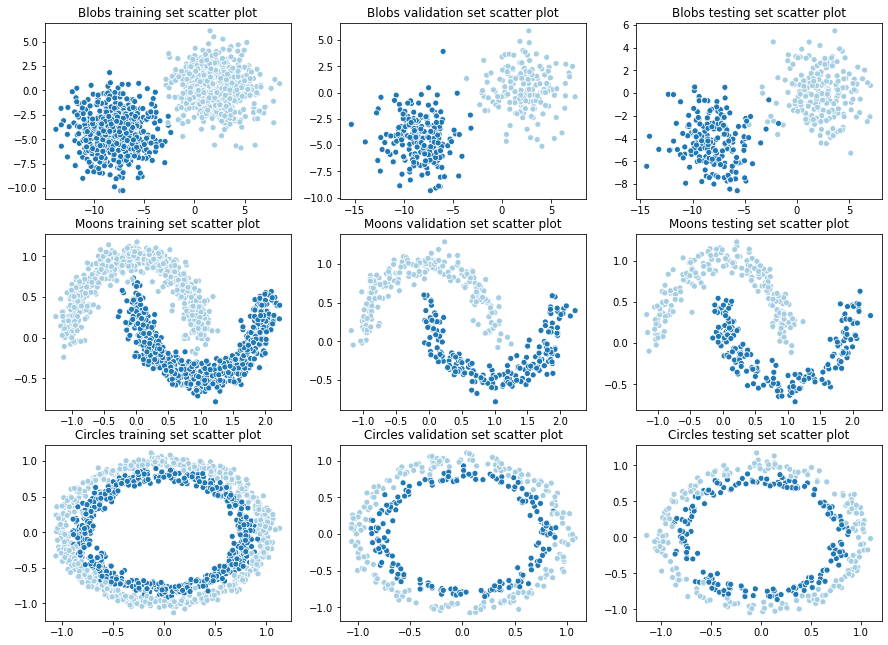

In [50]:
# Visualise the train, validate, test set.
fig, axes = plt.subplots(3,3, figsize=(15,11))
check_distribution(sample_blobs, sample_blobs_y, axes[0, :], name="Blobs")
check_distribution(sample_moons, sample_moons_y, axes[1, :], name="Moons")
check_distribution(sample_circles, sample_circles_y, axes[2, :], name="Circles")

plt.show()

## 1. Explore the original dataset
First, I trained the original dataset to convergence and get the best validation accuracy.

In [51]:
def train(x, y, classes, keep_best=5, selected_train=None, selected_train_y=None):
    x_train, x_valid, x_test = np.split(x, [int(.6 * len(x)), int(.8 * len(x))])
    y_train, y_valid, y_test = np.split(y, [int(.6 * len(y)), int(.8 * len(y))])
    
    # train with selected subset.
    if isinstance(selected_train, np.ndarray):
        x_train = selected_train
        y_train = selected_train_y
        print("Use selected {} samples to train the network.".format(len(y_train)))
        
    train_acc_list = []
    val_acc_list = []
    best_clf_list = []
    
    if classes != 1:
        y_train = to_categorical(y_train, num_classes=classes)
        y_valid = to_categorical(y_valid, num_classes=classes)
        y_test = to_categorical(y_test, num_classes=classes)
        
    for i in range(1):
        clf = keras.Sequential([
            keras.layers.InputLayer([2]),
            keras.layers.Dense(8, activation="tanh"),
            keras.layers.Dense(8, activation="tanh"),
            keras.layers.Dense(classes, activation='softmax', kernel_initializer="he_uniform")
        ])
        
        clf.compile(optimizer=keras.optimizers.Adam(0.05),
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

        history = {}
        
        default = clf.fit(x_train, y_train, batch_size=200, epochs=1000, validation_data=(x_valid, y_valid), verbose=0, callbacks=[
                                        MonitorAndSaveParameters(history, 200, len(y_valid),
                                                                 early_stop=True)])
        history["acc"] = default.history["accuracy"]
        history["loss"] = default.history["loss"]
#         show_training(history)
#     print("Evaluating...")
        val_acc_list.append(max(history["val_acc"])) 
        train_acc_list.append(history["acc"])
#         print("The training set accuracy is: {}".format(history["acc"][np.argmax(max(history["val_acc"]))]))
        best_clf_list.append(clf)
        if len(best_clf_list) > keep_best:
            worst_idx = np.argmin(val_acc_list)
            del best_clf_list[worst_idx]
            del val_acc_list[worst_idx]
            del train_acc_list[worst_idx]
    
    # Evaluate the best keep_best classifier
    test_acc_list = []
    for classifier in best_clf_list:
        evaluate = {}
        test_results = classifier.evaluate(x_test, y_test, batch_size=200, verbose=0, callbacks=[
                                MonitorAndSaveParameters(evaluate, 200, len(y_test))])
        acc = evaluate["val_acc"][0]
        test_acc_list.append(acc)
        print("The test set accuracy is: {:.3f}, the test set loss is: {:.3f}".format(acc, evaluate["val_loss"][0]))
        
    return best_clf_list, val_acc_list, train_acc_list, test_acc_list

### 1.1 Blobs

In [52]:
# train the blob dataset and report the evaluation acc.
clf_blobs, acc_blobs, acc_trend_blobs, acc_test_blobs = train(sample_blobs, sample_blobs_y, 2)

Restoring best model weights with validation accuracy: 1.0
The test set accuracy is: 0.995, the test set loss is: 0.085


### 1.2 Moons

In [53]:
clf_moons, acc_moons, acc_trend_moons, acc_test_moons = train(sample_moons, sample_moons_y, 2)

Restoring best model weights with validation accuracy: 1.0
The test set accuracy is: 1.000, the test set loss is: 0.000


##  1.3 Circles

In [54]:
clf_circles, acc_circles, acc_trend_circles, acc_test_circles = train(sample_circles, sample_circles_y, 2)

Restoring best model weights with validation accuracy: 0.9787500202655792
The test set accuracy is: 0.966, the test set loss is: 0.075


## 1.4 Show classification results

In [55]:
# plot the classification results.
blobs_y_pred = clf_blobs[np.argmax(acc_blobs)].predict_classes(sample_blobs)
moons_y_pred = clf_moons[np.argmax(acc_moons)].predict_classes(sample_moons)
circles_y_pred = clf_circles[np.argmax(acc_circles)].predict_classes(sample_circles)

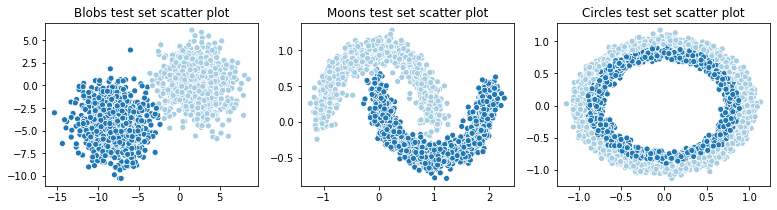

In [56]:
axes = plt.subplots(1,3, figsize=(13,3))
sns.scatterplot(sample_blobs[:,0], sample_blobs[:,1], hue=blobs_y_pred, ax=axes[1][0], legend=False, palette=sns.color_palette("Paired", 2))
axes[1][0].set_title("Blobs test set scatter plot")
sns.scatterplot(sample_moons[:,0], sample_moons[:,1], hue=moons_y_pred, ax=axes[1][1], legend=False, palette=sns.color_palette("Paired", 2))
axes[1][1].set_title("Moons test set scatter plot")
sns.scatterplot(sample_circles[:,0], sample_circles[:,1], hue=circles_y_pred, ax=axes[1][2], legend=False, palette=sns.color_palette("Paired", 2))
axes[1][2].set_title("Circles test set scatter plot")

ylim_blobs = axes[1][0].get_ylim()
xlim_blobs = axes[1][0].get_xlim()

ylim_moons = axes[1][1].get_ylim()
xlim_moons = axes[1][1].get_xlim()

ylim_circles = axes[1][2].get_ylim()
xlim_circles = axes[1][2].get_xlim()

plt.show()

## 2. Reduce the dataset with four different algorithms
Second, I reduced the original dataset and test the classification accuracy.

In [57]:
# init all four data reduction algorithms.
egdis = EGDIS()
pop = POP()
# CL needs the information about the dataset.
cl = CL()
wcl = WCL()

In [89]:
def run_pop(x, y, classes, ylim, xlim):
    x_train, x_valid, x_test = np.split(x, [int(.6 * len(x)), int(.8 * len(x))])
    y_train, y_valid, y_test = np.split(y, [int(.6 * len(y)), int(.8 * len(y))])
    print("Now try to run the algorithm POP with the generated sample dataset.")
    # test the pop algorithm
    sample_weakness = pop.fit(x_train, y_train)
    sample_weakness = pop.fit(x_train, y_train)
    sample_weakness = sample_weakness.astype(np.int64)
    fig = plt.figure(figsize=(10,5))
    ax = sns.countplot(sample_weakness, color="#3C76AF")
    ax.set_title("The distribution of the weakness")
    plt.show()
    print("------------------ Start to select subsets ------------------")
    
    trend_list = []
    test_list = []
    for i in range(int(sample_weakness.max())):
        selected_index = sample_weakness <= i
        selected_samples = x_train[selected_index]
        selected_y = y_train[selected_index]
        print("Keep instances with weakness <= {}, there are {} samples".format(i, len(selected_samples)))
        plot_y = y_train.copy()
        plot_y[selected_index] = classes
        ax = sns.scatterplot(x_train[:,0], x_train[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", classes+1))
        ax.set_title("Selected samples with the POP algorithm with weakness <= {}".format(i))
        plt.ylim(ylim)
        plt.xlim(xlim)
        plt.show()
        # train with the selected samples.
        clfs, accs, trend, test = train(x, y, classes, selected_train=selected_samples, selected_train_y=selected_y)
        
        trend_list.append(trend)
        test_list.append(test)
        
        y_pred = clfs[np.argmax(accs)].predict_classes(x)
        ax = sns.scatterplot(x[:,0], x[:,1], hue=y_pred, legend=False, palette=sns.color_palette("Paired", classes))
        ax.set_title("Predicted results with the highest validation accuracy classifier")
        plt.show()
        print("-----------------------------------------------------")
    
    return trend_list, test_list

In [97]:
def run_egdis(x, y, classes, ylim, xlim, askforboundary=False):
    x_train, x_valid, x_test = np.split(x, [int(.6 * len(x)), int(.8 * len(x))])
    y_train, y_valid, y_test = np.split(y, [int(.6 * len(y)), int(.8 * len(y))])
    
    
    if askforboundary:
        boundary_idx, _ = egdis.select_boundary(x_train, y_train)
        return boundary_idx
    else:    
        selected_egdis_idx = egdis.fit(x_train, y_train)
        print("Now try to run the algorithm EGDIS with the generated sample dataset.")
        print("Selected {} samples".format(len(selected_egdis_idx)))
        plot_y = y_train.copy()
        plot_y[selected_egdis_idx] = classes
        ax = sns.scatterplot(x_train[:,0], x_train[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", classes+1))
        ax.set_title("Samples selected by the EGDIS algorithm")
        plt.ylim(ylim)
        plt.xlim(xlim)
        plt.show()

        # train with the selected samples.
        clfs, accs, trend, test = train(x, y, classes, selected_train=x_train[selected_egdis_idx], selected_train_y=y_train[selected_egdis_idx])
        y_pred = clfs[np.argmax(accs)].predict_classes(x)
        ax = sns.scatterplot(x[:,0], x[:,1], hue=y_pred, legend=False, palette=sns.color_palette("Paired", classes))
        ax.set_title("Predicted results with the highest validation accuracy classifier")
        plt.show()
    return trend, test

In [60]:
def run_cl(x, y, classes, ylim, xlim, clf):
    x_train, x_valid, x_test = np.split(x, [int(.6 * len(x)), int(.8 * len(x))])
    y_train, y_valid, y_test = np.split(y, [int(.6 * len(y)), int(.8 * len(y))])
    cl.fit_dataset(clf=clf)
    rank, scores = cl.fit(x_train, to_categorical(y_train, num_classes=classes))
    
    trend_list = []
    test_list = []
    
    for i in range(1, 10, 2):
        percent = i / 10.
        selected_data_idx = np.random.choice(len(y_train), int(percent * len(y_train)), replace=False, p=scores / scores.sum())
        selected_x = x_train[selected_data_idx]
        selected_y = y_train[selected_data_idx]
        print("------------------ Start to select subsets ------------------")
        print("Selected {} percent training data.".format(i*10))
        
        plot_y = y_train.copy()
        plot_y[selected_data_idx] = classes
        ax = sns.scatterplot(x_train[:,0], x_train[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", classes+1))
        
        ax.set_title("{} percent Samples selected by the CL algorithm".format(i*10))
        plt.ylim(ylim)
        plt.xlim(xlim)
        plt.show()
        
        # train with the selected samples.
        clfs, accs, trend, test = train(x, y, classes, selected_train=selected_x, selected_train_y=selected_y)
        trend_list.append(trend)
        test_list.append(test)
        y_pred = clfs[np.argmax(accs)].predict_classes(x)
        ax = sns.scatterplot(x[:,0], x[:,1], hue=y_pred, legend=False, palette=sns.color_palette("Paired", classes))
        ax.set_title("Predicted results with the highest validation accuracy classifier")
        plt.show()
    return trend_list, test_list

In [94]:
def run_wcl(x_train, y_train, classes, tsne):
    print("Now try to run the WCL algorithm CL with generated datasets")
    wcl.fit_dataset(classes=10, dataset="cifar10")
    scores, selected_boundary_idx = wcl.fit(x_train, y_train, classes)
    print("Selected {} boundary instances.".format(len(selected_boundary_idx)))
    plot_y = y_train.copy()
    plot_y[selected_boundary_idx] = classes
    ax = sns.scatterplot(tsne[:,0], tsne[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", len(np.unique(plot_y))))
    ax.set_title("Selected {} boundary samples with EDGIS".format(len(selected_boundary_idx)))
    plt.show()
    
    for i in range(1, 10, 2):
        percent = i / 10.
        selected_data_idx = np.random.choice(len(y_train), int(percent * len(y_train)), replace=False, p=scores / scores.sum())
        print("Select {:.2f} percent samples, {} overlapping with the pre-selected boundary samples".format(percent*100, len(np.intersect1d(selected_boundary_idx, selected_data_idx)))) 
    return scores, selected_boundary_idx

##  2.1 Blobs

Now try to run the algorithm POP with the generated sample dataset.


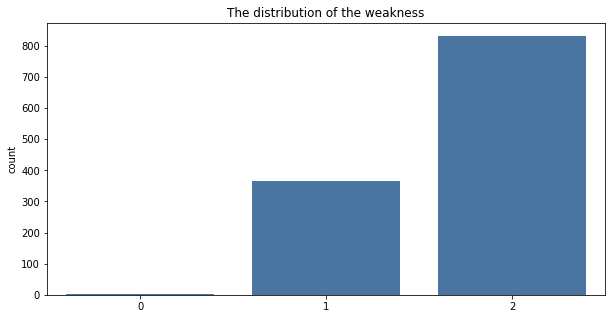

------------------ Start to select subsets ------------------
Keep instances with weakness <= 0, there are 3 samples


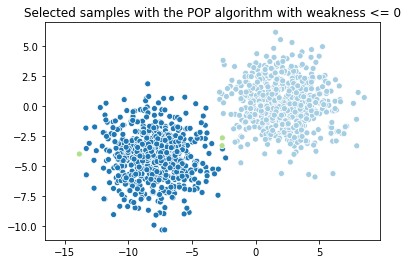

Use selected 3 samples to train the network.
Restoring best model weights with validation accuracy: 0.8537500202655792
The test set accuracy is: 0.851, the test set loss is: 0.444


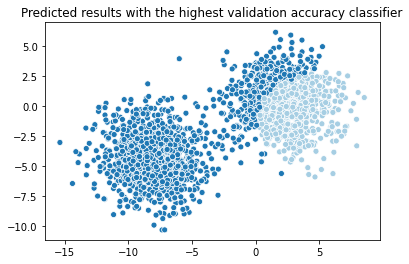

-----------------------------------------------------
Keep instances with weakness <= 1, there are 368 samples


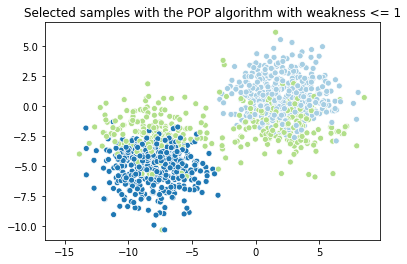

Use selected 368 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
The test set accuracy is: 0.988, the test set loss is: 0.059


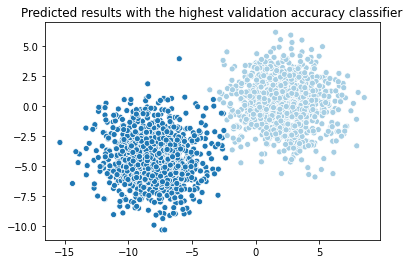

-----------------------------------------------------


In [90]:
trend_list, test_list = run_pop(sample_blobs, sample_blobs_y, 2, ylim_blobs, xlim_blobs)

Now try to run the algorithm EGDIS with the generated sample dataset.
Selected 136 samples


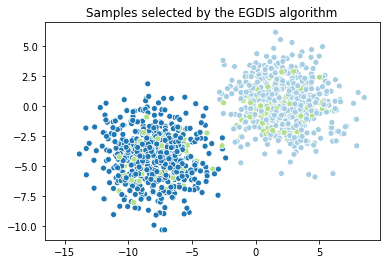

Use selected 136 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
The test set accuracy is: 0.993, the test set loss is: 0.091


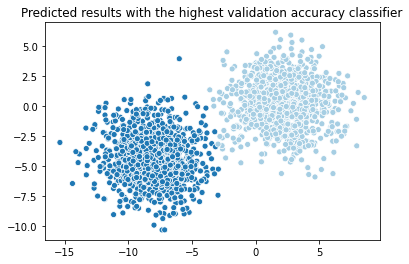

In [62]:
trend_list, test_list = run_egdis(sample_blobs, sample_blobs_y, 2, ylim_blobs, xlim_blobs)

In [99]:
boundary_idx_blob = run_egdis(sample_blobs, sample_blobs_y, 2, ylim_blobs, xlim_blobs, askforboundary=True)

In [100]:
len(boundary_idx_blob)

1

------------------ Start to select subsets ------------------
Selected 10 percent training data.


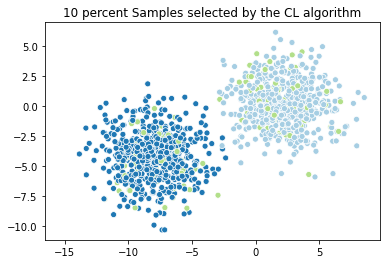

Use selected 120 samples to train the network.
Restoring best model weights with validation accuracy: 0.9962500035762787
The test set accuracy is: 0.985, the test set loss is: 0.100


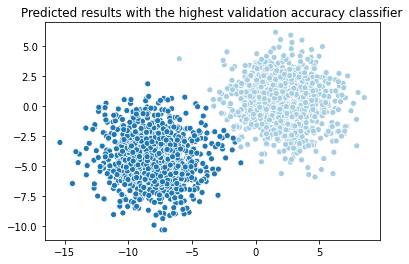

------------------ Start to select subsets ------------------
Selected 30 percent training data.


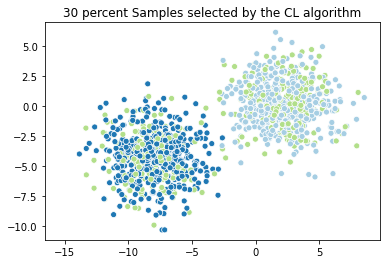

Use selected 360 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
The test set accuracy is: 0.988, the test set loss is: 0.094


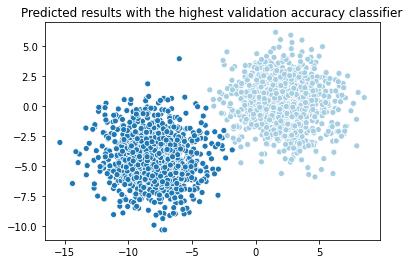

------------------ Start to select subsets ------------------
Selected 50 percent training data.


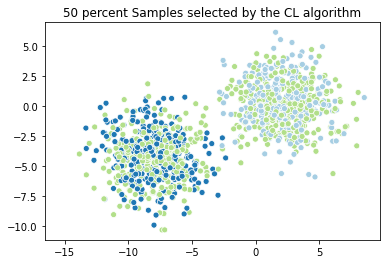

Use selected 600 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
The test set accuracy is: 0.994, the test set loss is: 0.093


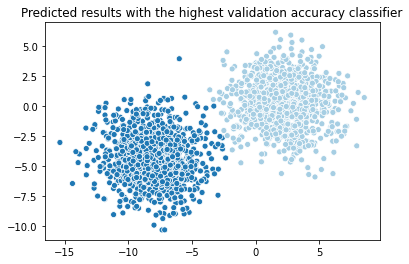

------------------ Start to select subsets ------------------
Selected 70 percent training data.


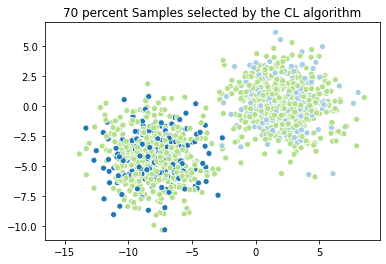

Use selected 840 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
The test set accuracy is: 0.994, the test set loss is: 0.112


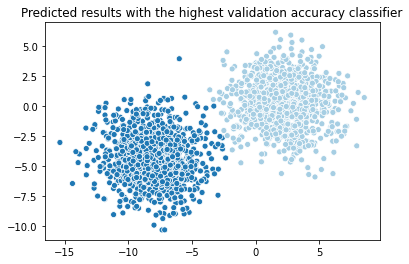

------------------ Start to select subsets ------------------
Selected 90 percent training data.


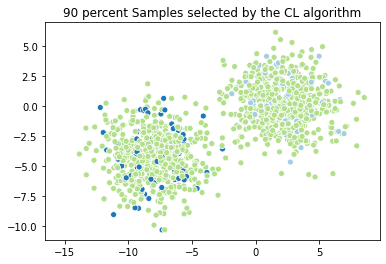

Use selected 1080 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
The test set accuracy is: 0.995, the test set loss is: 0.078


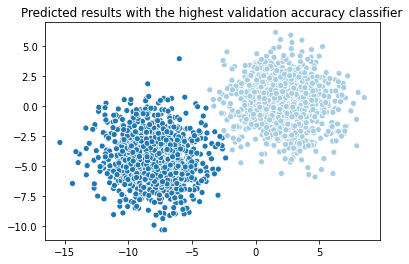

In [63]:
trend_list, test_list = run_cl(sample_blobs, sample_blobs_y, 2, ylim_blobs, xlim_blobs, clf_blobs[np.argmax(acc_blobs)])

In [20]:
# trend_list, test_list = run_wcl(sample_blobs, sample_blobs_y, ylim_blobs, xlim_blobs)

## 2.2 Moons

Now try to run the algorithm POP with the generated sample dataset.


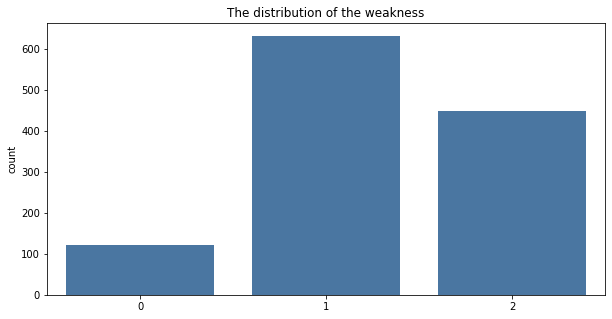

------------------ Start to select subsets ------------------
Keep instances with weakness <= 0, there are 121 samples


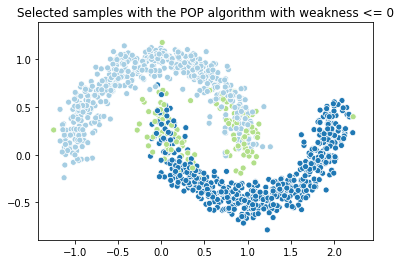

Use selected 121 samples to train the network.
Restoring best model weights with validation accuracy: 0.7100000083446503
The test set accuracy is: 0.750, the test set loss is: 0.933


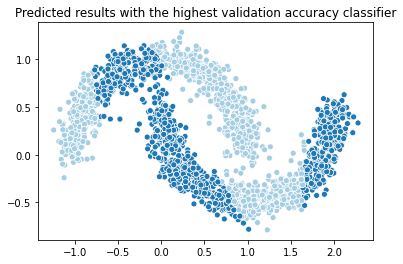

-----------------------------------------------------
Keep instances with weakness <= 1, there are 752 samples


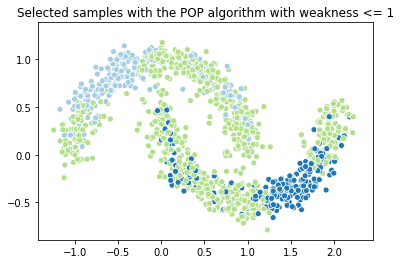

Use selected 752 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
The test set accuracy is: 1.000, the test set loss is: 0.000


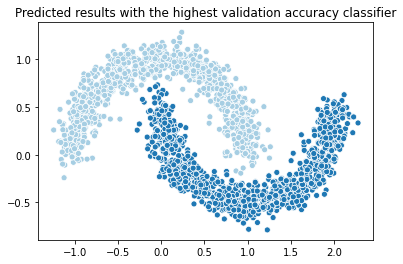

-----------------------------------------------------


In [91]:
trend_list, test_list = run_pop(sample_moons, sample_moons_y, 2, ylim_moons, xlim_moons)

Now try to run the algorithm EGDIS with the generated sample dataset.
Selected 177 samples


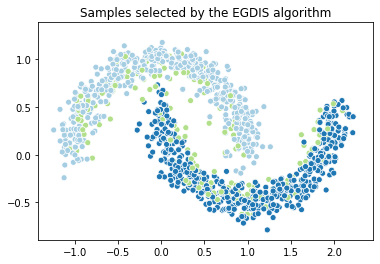

Use selected 177 samples to train the network.
Restoring best model weights with validation accuracy: 0.9987500011920929
The test set accuracy is: 1.000, the test set loss is: 0.001


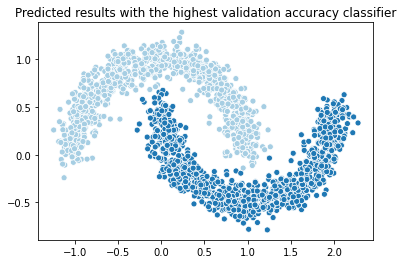

In [65]:
trend_list, test_list = run_egdis(sample_moons, sample_moons_y, 2, ylim_moons, xlim_moons)

In [102]:
boundary_idx_moons = run_egdis(sample_moons, sample_moons_y, 2, ylim_blobs, xlim_blobs, askforboundary=True)

In [103]:
len(boundary_idx_moons)

3

------------------ Start to select subsets ------------------
Selected 10 percent training data.


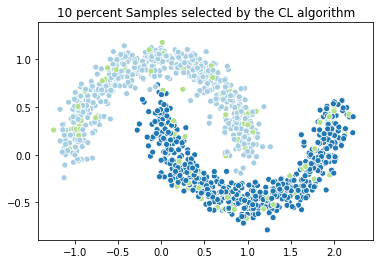

Use selected 120 samples to train the network.
Restoring best model weights with validation accuracy: 0.9987500011920929
The test set accuracy is: 0.999, the test set loss is: 0.004


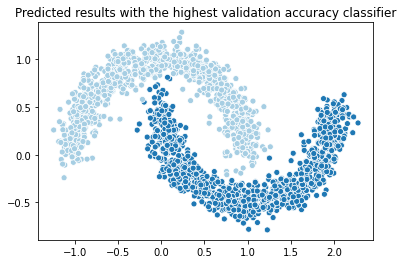

------------------ Start to select subsets ------------------
Selected 30 percent training data.


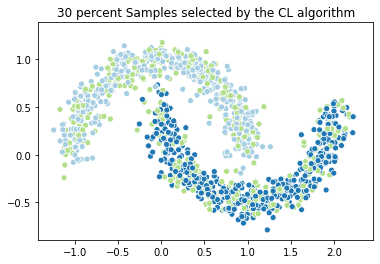

Use selected 360 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
The test set accuracy is: 0.999, the test set loss is: 0.002


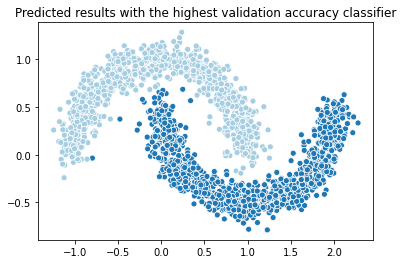

------------------ Start to select subsets ------------------
Selected 50 percent training data.


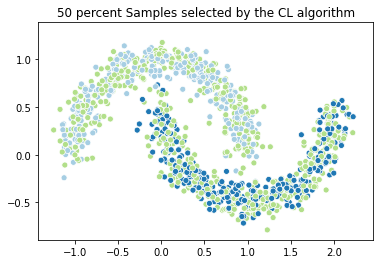

Use selected 600 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
The test set accuracy is: 0.999, the test set loss is: 0.003


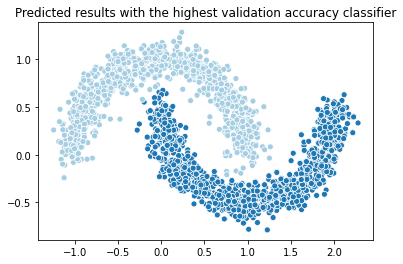

------------------ Start to select subsets ------------------
Selected 70 percent training data.


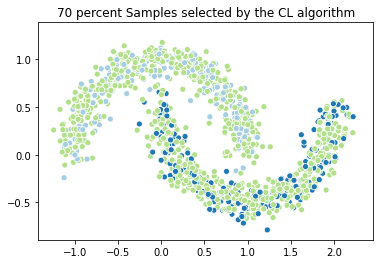

Use selected 840 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
The test set accuracy is: 1.000, the test set loss is: 0.000


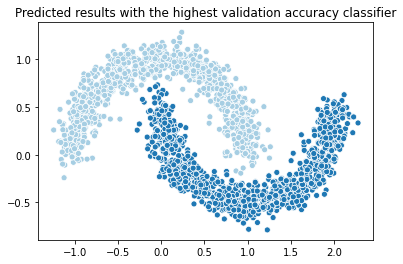

------------------ Start to select subsets ------------------
Selected 90 percent training data.


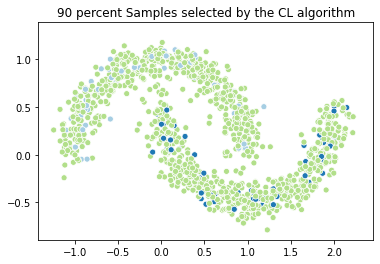

Use selected 1080 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
The test set accuracy is: 1.000, the test set loss is: 0.000


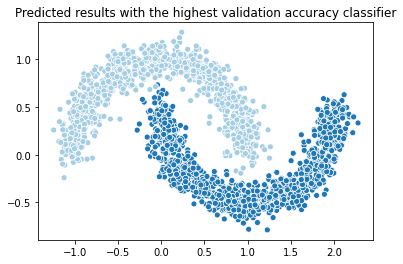

In [66]:
trend_list, test_list = run_cl(sample_moons, sample_moons_y, 2, ylim_moons, xlim_moons, clf_moons[np.argmax(acc_moons)])

## 2.3 Circles

Now try to run the algorithm POP with the generated sample dataset.


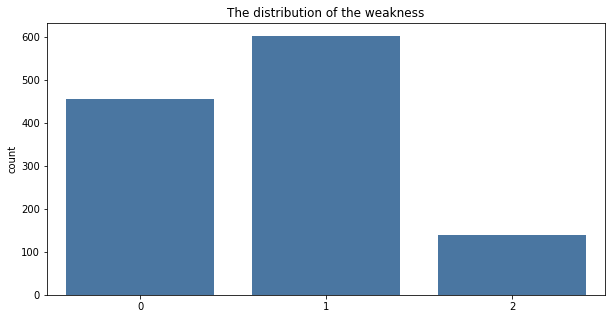

------------------ Start to select subsets ------------------
Keep instances with weakness <= 0, there are 457 samples


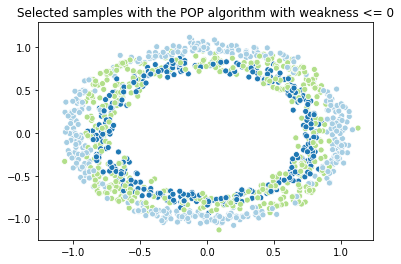

Use selected 457 samples to train the network.
Restoring best model weights with validation accuracy: 0.961249977350235
The test set accuracy is: 0.945, the test set loss is: 0.128


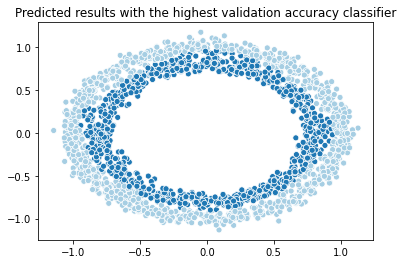

-----------------------------------------------------
Keep instances with weakness <= 1, there are 1060 samples


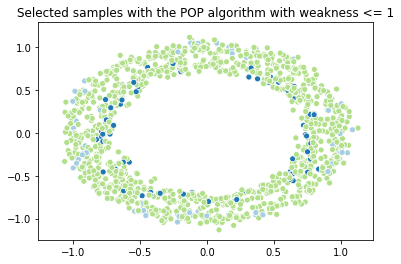

Use selected 1060 samples to train the network.
Restoring best model weights with validation accuracy: 0.9800000190734863
The test set accuracy is: 0.963, the test set loss is: 0.086


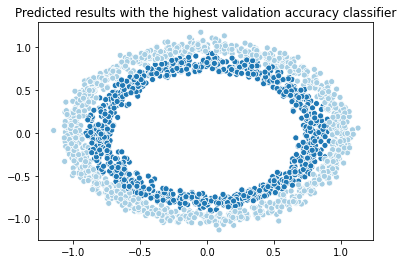

-----------------------------------------------------


In [92]:
trend_list, test_list = run_pop(sample_circles, sample_circles_y, 2, ylim_circles, xlim_circles)

Now try to run the algorithm EGDIS with the generated sample dataset.
Selected 202 samples


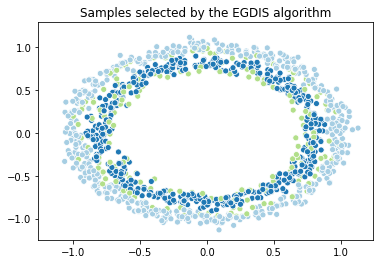

Use selected 202 samples to train the network.
Restoring best model weights with validation accuracy: 0.7462500035762787
The test set accuracy is: 0.785, the test set loss is: 0.457


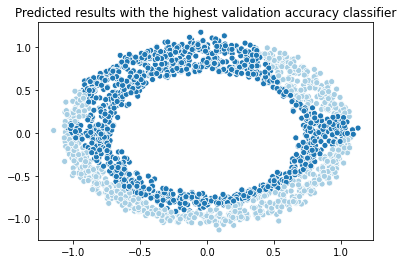

In [106]:
trend_list, test_list = run_egdis(sample_circles, sample_circles_y, 2, ylim_circles, xlim_circles)

In [104]:
boundary_idx_circles = run_egdis(sample_circles, sample_circles_y, 2, ylim_blobs, xlim_blobs, askforboundary=True)

In [105]:
len(boundary_idx_circles)

35

------------------ Start to select subsets ------------------
Selected 10 percent training data.


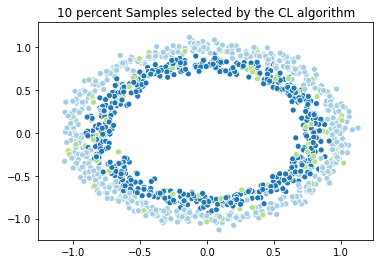

Use selected 120 samples to train the network.
Restoring best model weights with validation accuracy: 0.9737499952316284
The test set accuracy is: 0.965, the test set loss is: 0.081


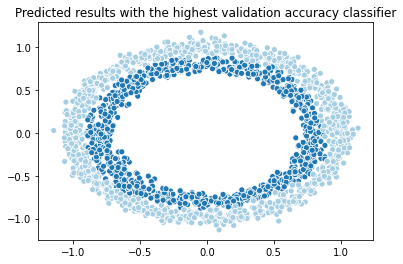

------------------ Start to select subsets ------------------
Selected 30 percent training data.


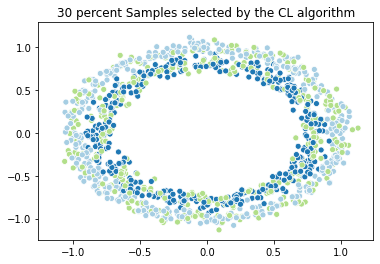

Use selected 360 samples to train the network.
Restoring best model weights with validation accuracy: 0.9800000190734863
The test set accuracy is: 0.971, the test set loss is: 0.105


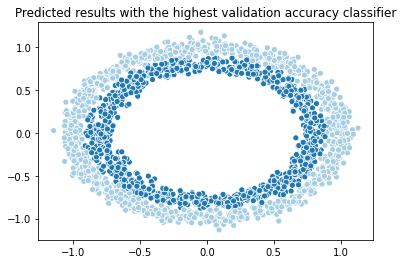

------------------ Start to select subsets ------------------
Selected 50 percent training data.


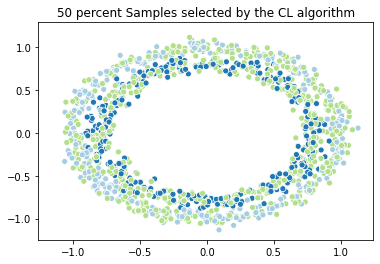

Use selected 600 samples to train the network.
Restoring best model weights with validation accuracy: 0.976250022649765
The test set accuracy is: 0.951, the test set loss is: 0.127


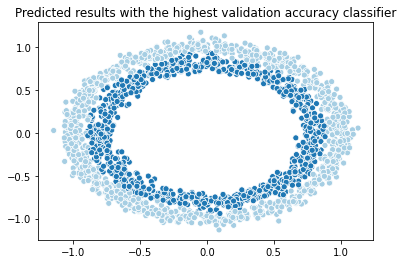

------------------ Start to select subsets ------------------
Selected 70 percent training data.


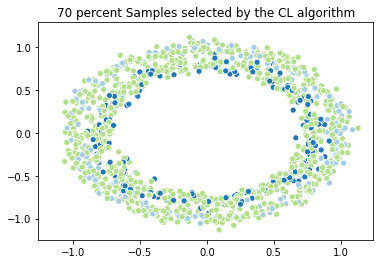

Use selected 840 samples to train the network.
Restoring best model weights with validation accuracy: 0.9775000214576721
The test set accuracy is: 0.974, the test set loss is: 0.104


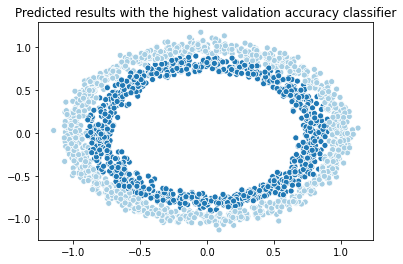

------------------ Start to select subsets ------------------
Selected 90 percent training data.


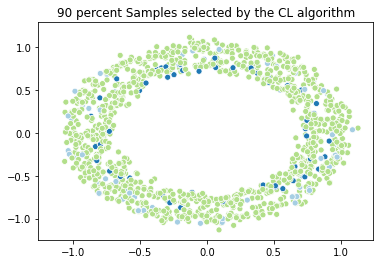

Use selected 1080 samples to train the network.
Restoring best model weights with validation accuracy: 0.9775000214576721
The test set accuracy is: 0.961, the test set loss is: 0.095


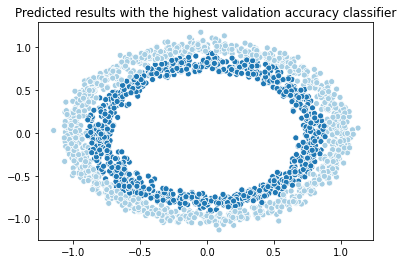

In [69]:
trend_list, test_list = run_cl(sample_circles, sample_circles_y, 2, ylim_circles, xlim_circles, clf_circles[np.argmax(acc_circles)])

## Comment
EGDIS can select samples around the boundary. Therefore the relative accuracy is high. POP and CL are not stable. They cannot cover the whole boundary. Actually, because the scores are all above 0.9, the selection process tends to be uniform random selection. Also, CL tends to select inner samples because they have higher classification scores.

## 3. CL Score distribution analysis
Now we plot the score distribution acquired by CL to show illustrate how CL works

In [70]:
def show_CL_scores(x, y, classes, ylim, xlim, clf, percent_mode=False):
    x_train, x_valid, x_test = np.split(x, [int(.6 * len(x)), int(.8 * len(x))])
    y_train, y_valid, y_test = np.split(y, [int(.6 * len(y)), int(.8 * len(y))])
    cl.fit_dataset(clf=clf)
    rank, scores = cl.fit(x_train, to_categorical(y_train, num_classes=classes))
    ax = sns.distplot(scores, kde=True, rug=True, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]);
    ax.set_title("The distribution of the CL scores")
    plt.show()
    image_idx = 0
    color_palette = ["#3E77B0", "#AECDE1", "#BBDE93"]
    fig, axes = plt.subplots(3, 3, figsize=(16,13))
    for i in range(9, 0, -1):
        score = i / 10.
        plot_y = y_train.copy()
        if percent_mode:
            percent = 1 - score
            selected_data_idx = np.random.choice(len(y_train), int(percent * len(y_train)), replace=False, p=scores / scores.sum())
            plot_y[selected_data_idx] = classes
            ax = sns.scatterplot(x_train[:,0], x_train[:,1], ax=axes[image_idx//3][image_idx%3], hue=plot_y, legend=False, palette=sns.color_palette("Paired", classes+1))
            ax.set_title("Top {:.2f} percent, {} samples".format(percent, len(selected_data_idx)))
            
        else:
            if len(plot_y[scores >= score]) == len(y_train):
                plot_y[scores >= score] = 0
                ax = sns.scatterplot(x_train[:,0], x_train[:,1], ax=axes[image_idx//3][image_idx%3], hue=plot_y, legend=False, palette=sns.color_palette(["#BBDE93"]))
            else:
                plot_y[scores >= score] = classes
                selected_palette = [color_palette[idx] for idx in np.unique(plot_y)]
                ax = sns.scatterplot(x_train[:,0], x_train[:,1], ax=axes[image_idx//3][image_idx%3], hue=plot_y, legend=False, palette=sns.color_palette(selected_palette))
            ax.set_title("Scores >= {}, {} samples".format(score, (scores >= score).sum()))
        image_idx += 1
        plt.ylim(ylim)
        plt.xlim(xlim)
    plt.show()
                
        

## 3.1 Blobs

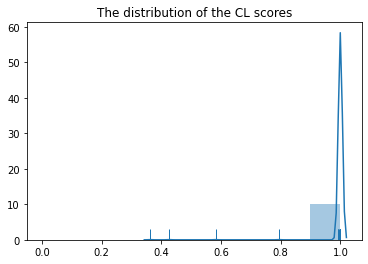

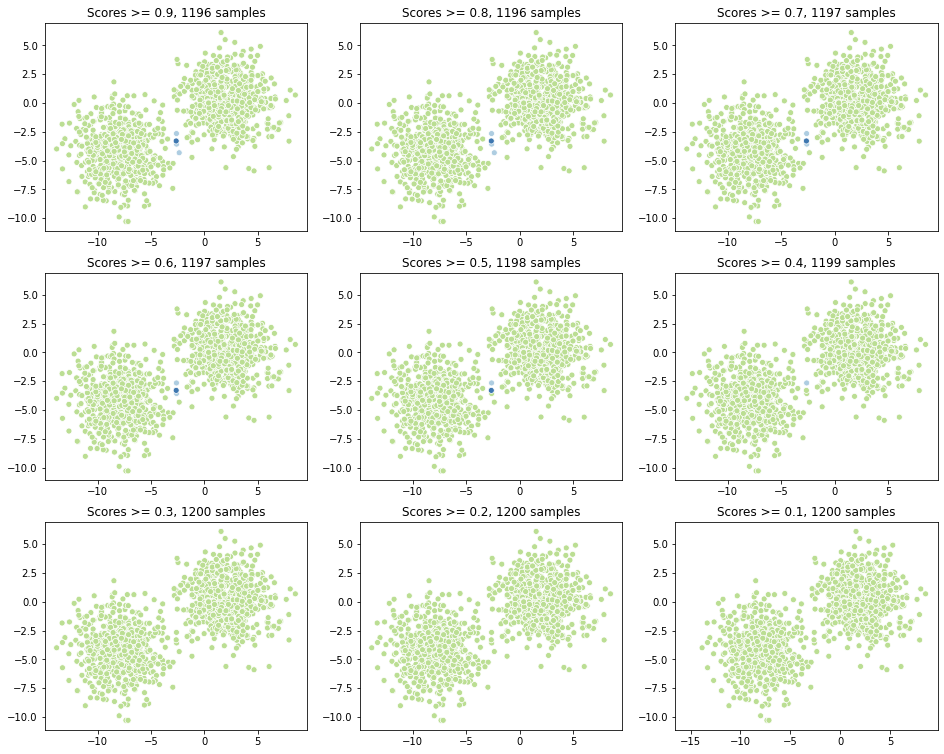

In [87]:
show_CL_scores(sample_blobs, sample_blobs_y, 2, ylim_blobs, xlim_blobs, clf=clf_blobs[np.argmax(acc_blobs)])

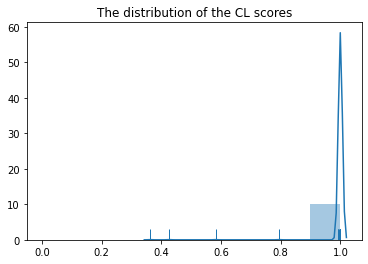

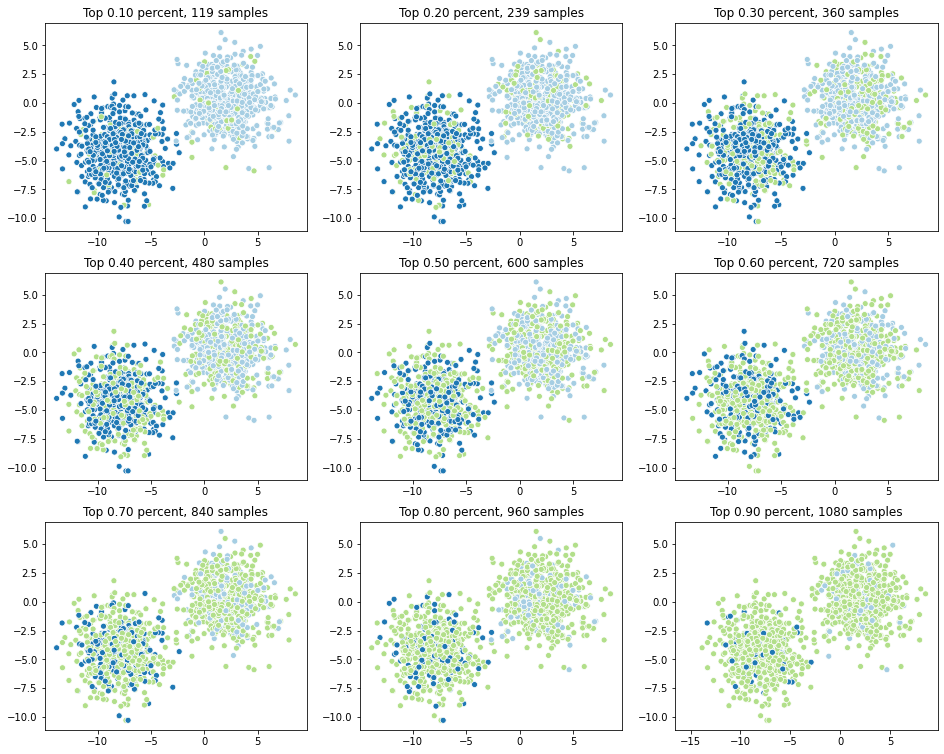

In [72]:
show_CL_scores(sample_blobs, sample_blobs_y, 2, ylim_blobs, xlim_blobs, clf=clf_blobs[np.argmax(acc_blobs)], percent_mode=True)

## 3.2 Moons

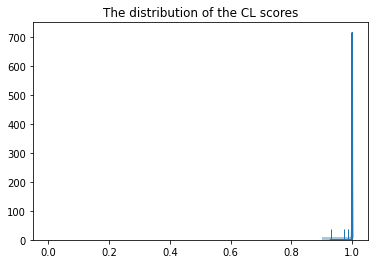

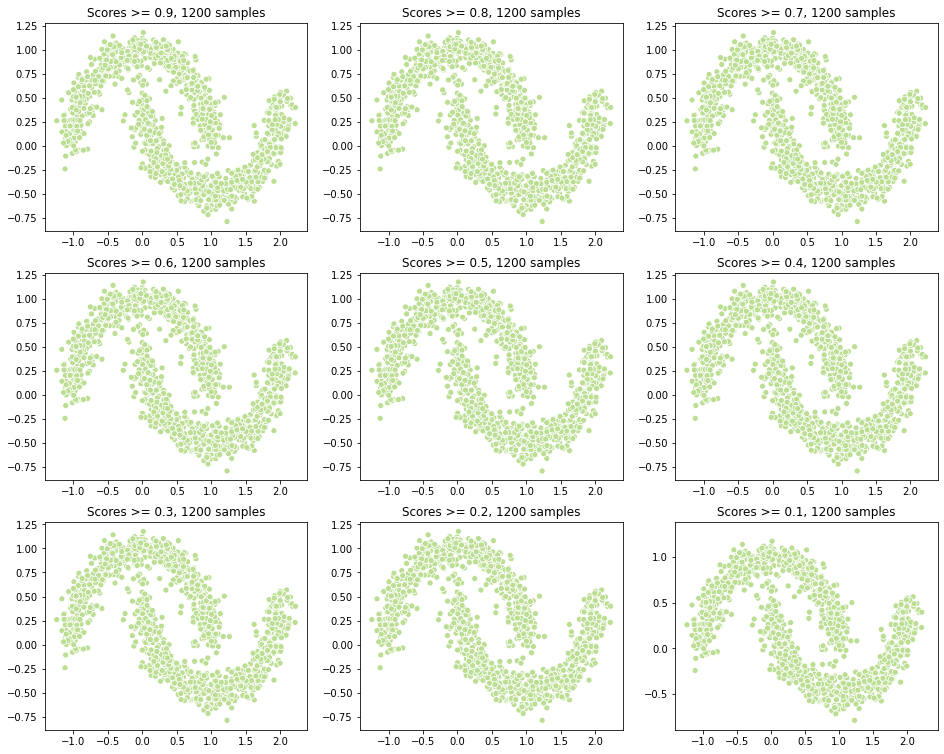

In [86]:
show_CL_scores(sample_moons, sample_moons_y, 2, ylim_moons, xlim_moons, clf=clf_moons[np.argmax(acc_moons)])

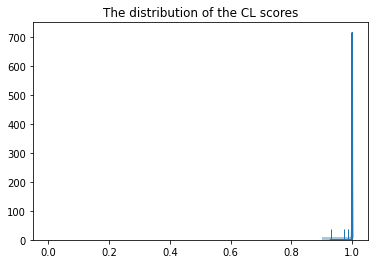

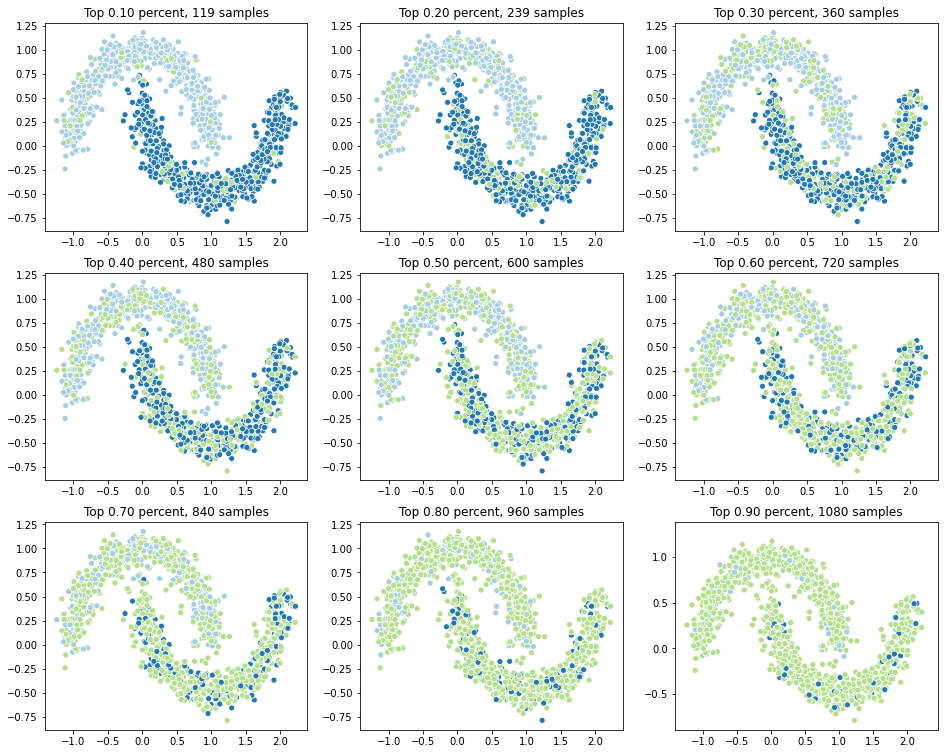

In [83]:
show_CL_scores(sample_moons, sample_moons_y, 2, ylim_moons, xlim_moons, clf=clf_moons[np.argmax(acc_moons)], percent_mode=True)

## 3.3 Circles

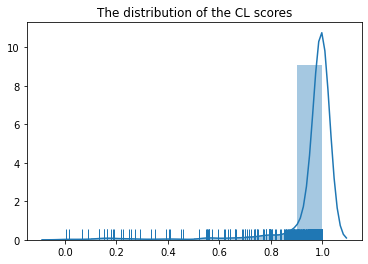

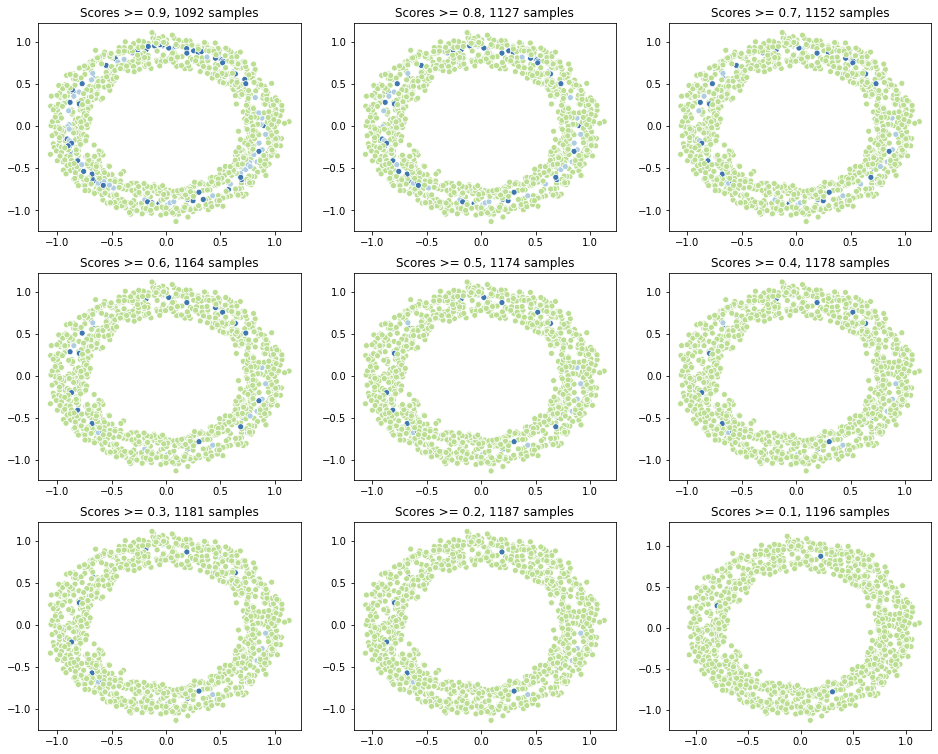

In [84]:
show_CL_scores(sample_circles, sample_circles_y, 2, ylim_circles, xlim_circles, clf=clf_circles[np.argmax(acc_circles)])

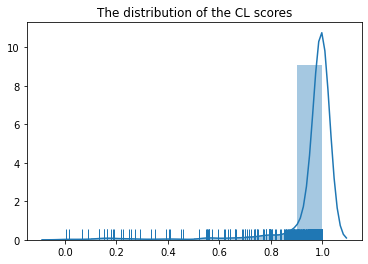

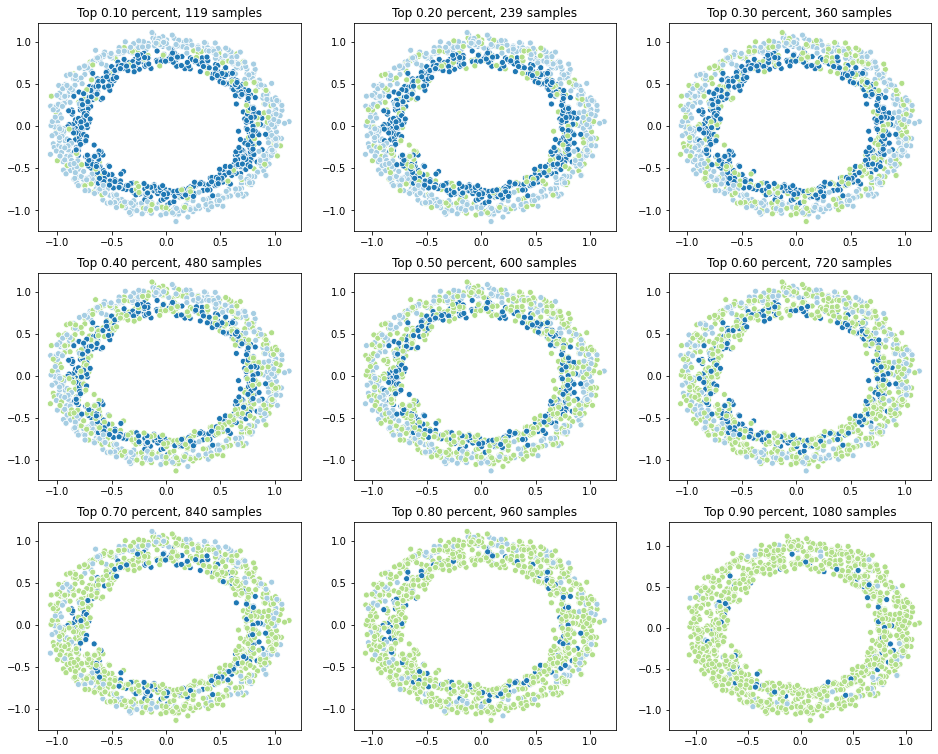

In [85]:
show_CL_scores(sample_circles, sample_circles_y, 2, ylim_circles, xlim_circles, clf=clf_circles[np.argmax(acc_circles)], percent_mode=True)

## 4. Calculate the intersection of selected points with CL and EDGIS boundary

In [77]:
def run_wcl(x, y, classes, ylim, xlim, clf):
    x_train, x_valid, x_test = np.split(x, [int(.6 * len(x)), int(.8 * len(x))])
    y_train, y_valid, y_test = np.split(y, [int(.6 * len(y)), int(.8 * len(y))])
    wcl.fit_dataset(clf=clf)
    scores, selected_boundary_idx = wcl.fit(x_train, y_train, classes)
    print("Selected {} boundary instances.".format(len(selected_boundary_idx)))
    plot_y = y_train.copy()
    plot_y[selected_boundary_idx] = classes
    ax = sns.scatterplot(x_train[:,0], x_train[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", classes+1))
    ax.set_title("Selected {} boundary samples with EDGIS".format(len(selected_boundary_idx)))
    plt.show()
    
    for i in range(1, 10, 2):
        percent = i / 10.
        selected_data_idx = np.random.choice(len(y_train), int(percent * len(y_train)), replace=False, p=scores / scores.sum())
        print("Select {:.2f} percent samples, {} overlapping with the pre-selected boundary samples".format(percent*100, len(np.intersect1d(selected_boundary_idx, selected_data_idx)))) 
        

## 4.1 Blobs

Selected 1 boundary instances.


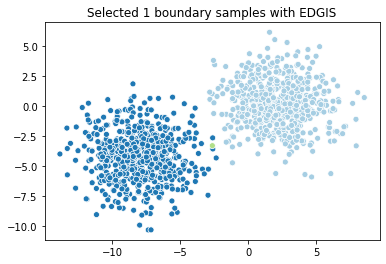

Select 10.00 percent samples, 0 overlapping with the pre-selected boundary samples
Select 30.00 percent samples, 0 overlapping with the pre-selected boundary samples
Select 50.00 percent samples, 1 overlapping with the pre-selected boundary samples
Select 70.00 percent samples, 0 overlapping with the pre-selected boundary samples
Select 90.00 percent samples, 0 overlapping with the pre-selected boundary samples


In [78]:
run_wcl(sample_blobs, sample_blobs_y, 2, ylim_blobs, xlim_blobs, clf=clf_blobs[np.argmax(acc_blobs)])

## 4.2 Moons

Selected 3 boundary instances.


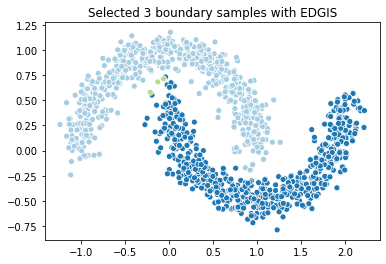

Select 10.00 percent samples, 2 overlapping with the pre-selected boundary samples
Select 30.00 percent samples, 1 overlapping with the pre-selected boundary samples
Select 50.00 percent samples, 2 overlapping with the pre-selected boundary samples
Select 70.00 percent samples, 1 overlapping with the pre-selected boundary samples
Select 90.00 percent samples, 3 overlapping with the pre-selected boundary samples


In [79]:
run_wcl(sample_moons, sample_moons_y, 2, ylim_moons, xlim_moons, clf=clf_moons[np.argmax(acc_moons)])

## 4.3 Circles

Selected 35 boundary instances.


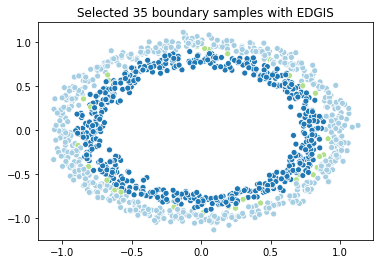

Select 10.00 percent samples, 0 overlapping with the pre-selected boundary samples
Select 30.00 percent samples, 3 overlapping with the pre-selected boundary samples
Select 50.00 percent samples, 7 overlapping with the pre-selected boundary samples
Select 70.00 percent samples, 8 overlapping with the pre-selected boundary samples
Select 90.00 percent samples, 19 overlapping with the pre-selected boundary samples


In [80]:
run_wcl(sample_circles, sample_circles_y, 2, ylim_circles, xlim_circles, clf=clf_circles[np.argmax(acc_circles)])